## Feature Selection by Random Shuffling

We can implement feature selection by feature shuffling with Feature-engine.

The selector takes any machine learning algorithm as input, and any metric from those allowed by Scikit-learn.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

from feature_engine.selection import SelectByShuffling

## Classification

In [2]:
# load dataset
data = pd.read_csv('../dataset_2.csv')
data.shape

(50000, 109)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

### Set up Random Forests

In [5]:
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

### Set up Shuffle features Selector

In [6]:
sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=3, # cross validation
    random_state=1 # seed
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestClassifier(max_depth=2, n_estimators=50,
                                                   n_jobs=4,
                                                   random_state=2909),
                  random_state=1, threshold=0)

In [7]:
# performance of model trained with all features

sel.initial_model_performance_

0.6854579498672484

In [8]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'var_1': -0.0057691905141851185,
 'var_2': -0.005846604542057876,
 'var_3': -0.0057691905141851185,
 'var_4': -0.0057691905141851185,
 'var_5': -0.005734970955169616,
 'var_6': -0.0057704975762510324,
 'var_7': -0.005674453607000807,
 'var_8': -0.0057691905141851185,
 'var_9': -0.0057691905141851185,
 'var_10': -0.0057404403919636415,
 'var_11': -0.005738781284527428,
 'var_12': -0.0057691905141851185,
 'var_13': -0.005820731454446726,
 'var_14': -0.005723173690104666,
 'var_15': -0.0057691905141851185,
 'var_16': 0.008153378442915304,
 'var_17': -0.005829992494781,
 'var_18': -0.0057691905141851185,
 'var_19': -0.005822129898502393,
 'var_20': -0.0057691905141851185,
 'var_21': -0.0056212011270138085,
 'var_22': -0.005787500618598673,
 'var_23': -0.0057691905141851185,
 'var_24': -0.005764745005095495,
 'var_25': -0.0057691905141851185,
 'var_26': -0.005761978827325209,
 'var_27': -0.0057691905141851185,
 'var_28': -0.0057691905141851185,
 'var_29': -0.005736060048719183,
 'var_30': 

<AxesSubplot:>

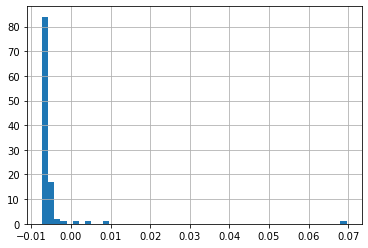

In [9]:
# histogram of the performance drops

pd.Series(sel.performance_drifts_).hist(bins=50)

<AxesSubplot:>

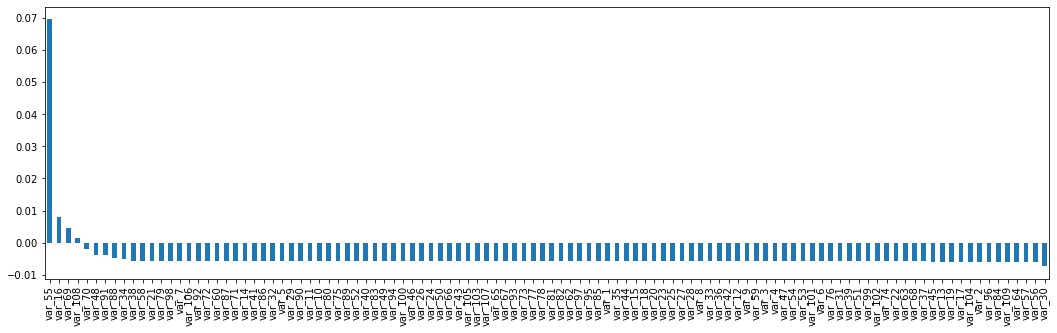

In [10]:
# bar plot of the performance drops

pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

In [11]:
# features that will be removed

len(sel.features_to_drop_)

101

In [12]:
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 7), (15000, 7))

In [13]:
# build a random forests only with the selected features

rf.fit(X_train, y_train)

# print roc-auc in train and testing sets
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))

train auc score:  0.7010001123593995
test auc score:  0.6953477325844082


The random forests with the selected features show a similar performance (or even slightly higher) to the random forests built using all of the features.

## B) Regression

In [14]:
# load dataset

data = pd.read_csv('../houseprice.csv')
data.shape

(1460, 81)

In [15]:
# here for simplicity to use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [16]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [17]:
# fill missing values

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Train ML algo with all features

In [18]:
# build few and shallow trees to avoid overfitting
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=3,
                           random_state=2909,
                           n_jobs=4)


### Shuffle features and asses performance drift

In [19]:
sel = SelectByShuffling(
    variables=None,
    estimator=rf, 
    scoring='neg_root_mean_squared_error',
    threshold=None,
    cv=3,
    random_state=1
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestRegressor(max_depth=3, n_jobs=4,
                                                  random_state=2909),
                  random_state=1, scoring='neg_root_mean_squared_error')

In [20]:
# performance of model trained using all features

sel.initial_model_performance_

-37824.88457786946

<AxesSubplot:>

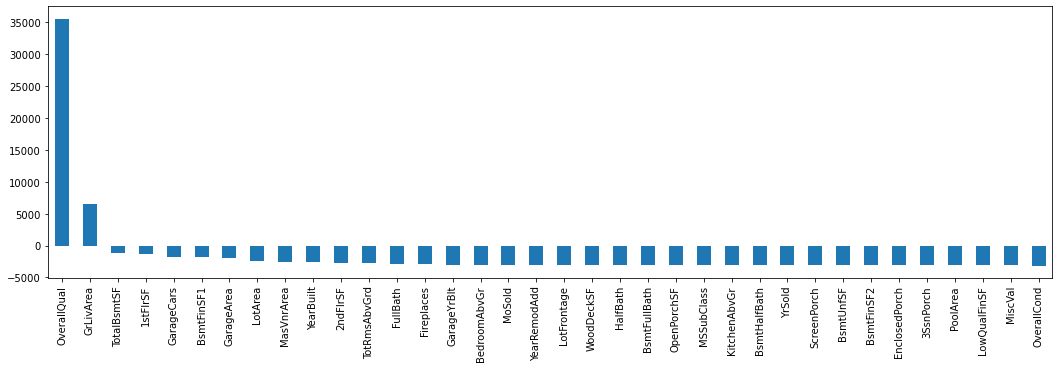

In [21]:
# performance drifts

pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

In [22]:
sel.features_to_drop_

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [23]:
# select the features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((1022, 4), (438, 4))

In [24]:
# check model performance using only selected features
rf.fit(X_train, y_train)

# print performance metrics
print('train rmse: ', mean_squared_error(y_train, rf.predict(X_train), squared=False))
print('train r2: ', r2_score(y_train, (rf.predict(X_train))))
print()
print('test rmse: ', mean_squared_error(y_test, rf.predict(X_test), squared=False))
print('test r2: ', r2_score(y_test, rf.predict(X_test)))

train rmse:  35958.5144285725
train r2:  0.7880218953729026

test rmse:  40006.14519421907
test r2:  0.7642519264873466


The model with less features shows similar performance to that with all features.